In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema

from loren_frank_data_processing import (make_epochs_dataframe, make_neuron_dataframe)
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)
from ZilongCode.utils import get_sweep_and_awake_replay_results

In [3]:
def get_unique_nan_index(corr_matrix):
    '''
    Get the unique column index of the nan value in the corr_matrix
    that is, the index that have nan value in the corr_matrix
    This nan value exsists because it is a W shape track with decision point 
    Input:
        corr_matrix: the correlation matrix of the ground process intensities
    Output:
        unique_nan_index: the unique column index of the nan value in the corr_matrix
    '''
    nan_index = np.argwhere(np.isnan(corr_matrix))
    #get nan_index when the first element is 0
    firstraw_nan_index = nan_index[nan_index[:, 0] == 0]
    #get the unique column index in firstraw_nan_index
    unique_nan_index = np.unique(firstraw_nan_index[:, 1])
    return unique_nan_index

In [4]:
def get_population_vector_correlation_perbin(classifier, epoch_key, DATA_DIR, smooth_sigma=3, plot=True):
    '''
    Get the correlation matrix of the ground process intensities
    Input:
        classifier: the classifier trained with the state-space model
        epoch_key: the key of the epoch
        DATA_DIR: the directory of the data
        plot: whether to plot the correlation matrix
    Output:
        correlation_decay_per_bin: the correlation decay per bin
    '''
    
    animal, day, epoch = epoch_key  
        
    #change to array and squeeze to get rid of the extra dimension
    intensity = np.array(classifier.ground_process_intensities_).squeeze()
    #get the correlation matrix of the ground process intensities
    corr_matrix = np.corrcoef(intensity.T)
    
    unique_nan_index = get_unique_nan_index(corr_matrix)
    
    rightarm_len = unique_nan_index[1]-unique_nan_index[0]
    leftarm_len = len(corr_matrix)-unique_nan_index[1]
    
    #keep columns and rows of the corr_matrix until the unique_nan_index[1]
    rightarm_corr_matrix = corr_matrix[:unique_nan_index[1], :unique_nan_index[1]]
    
    #keep columns and rows of the corr_matrix from 0 to unique_nan_index[0], 
    # and unique_nan_index[1] to len(corr_matrix)
    row_index  = np.arange(0, unique_nan_index[0])  
    row_index = np.append(row_index, np.arange(unique_nan_index[1], len(corr_matrix)))
    column_index = row_index
    leftarm_corr_matrix = corr_matrix[row_index, :][:, column_index]
    
    #get the diagonal sum of the rightarm_corr_matrix
    diagonal_sums_rightarm = []
    Offsets_rightarm = np.arange(-len(rightarm_corr_matrix) + 1, len(rightarm_corr_matrix))
    for offset in Offsets_rightarm:
        #diagonal_sum_r = np.nansum(np.diagonal(rightarm_corr_matrix, offset=offset))
        #get nanmean
        diagonal_sum_r = np.nanmean(np.diagonal(rightarm_corr_matrix, offset=offset))
        diagonal_sums_rightarm.append(diagonal_sum_r)
    
    #get the diagonal sum of the leftarm_corr_matrix    
    diagonal_sums_leftarm = []
    Offsets_leftarm = np.arange(-len(leftarm_corr_matrix) + 1, len(leftarm_corr_matrix))
    for offset in Offsets_leftarm:
        #diagonal_sum_l = np.nansum(np.diagonal(leftarm_corr_matrix, offset=offset))
        #get nanmean
        diagonal_sum_l = np.nanmean(np.diagonal(leftarm_corr_matrix, offset=offset))
        diagonal_sums_leftarm.append(diagonal_sum_l)
        
    #aveage diagonal_sums of the right arm and left arm, since they have different length
    if len(Offsets_rightarm) > len(Offsets_leftarm):
        cuts = (len(Offsets_rightarm) - len(Offsets_leftarm))/2
        diagonal_sums_rightarm = diagonal_sums_rightarm[int(cuts):int(-cuts)]
        Offsets = Offsets_leftarm
    elif len(Offsets_rightarm) < len(Offsets_leftarm):
        cuts = (len(Offsets_leftarm) - len(Offsets_rightarm))/2
        diagonal_sums_leftarm = diagonal_sums_leftarm[int(cuts):int(-cuts)]
        Offsets = Offsets_rightarm
    else:
        Offsets = Offsets_rightarm
    mean_diagonal_sums = (np.array(diagonal_sums_rightarm) + np.array(diagonal_sums_leftarm))/2 
    
    #smooth the mean_diagonal_sums
    smoothed_mean_diagonal_sums = gaussian_filter1d(mean_diagonal_sums, sigma=smooth_sigma)
    try:
        #find index of all local minimas on the smoothed_mean_diagonal_sums
        local_minima_index = argrelextrema(smoothed_mean_diagonal_sums, np.less)[0]
        #keep the smallest positive index and the largest negative index
        center = int(len(smoothed_mean_diagonal_sums)/2)
        #subtract each element in local_minima_index by center
        local_minima_index = local_minima_index - center
        #find the smallest positive index
        smallest_positive_index = np.min(local_minima_index[local_minima_index>0])
        #find the largest negative index
        largest_negative_index = np.max(local_minima_index[local_minima_index<0])
        #fidn the width between the smallest positive index and the largest negative index
        width = smallest_positive_index - largest_negative_index
        #add back the center to [largest_negative_index, smallest_positive_index]
        local_minima_index = np.asarray([largest_negative_index, smallest_positive_index]) + center
        
        correlation_decay_per_bin = smoothed_mean_diagonal_sums[center] - smoothed_mean_diagonal_sums[smallest_positive_index+center] 
        correlation_decay_per_bin = correlation_decay_per_bin/(width/2)
        
    except:
        #set width as nan
        width = np.nan
        correlation_decay_per_bin = np.nan
        local_minima_index = []
    
    if plot == True:
        fig = plt.figure(figsize=(10, 3))
        #grid spec
        gs = GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[4, 1.5, 2])
        
        plt.subplot(gs[:, 0])
        #imshow of the correlation matrix
        #set raw: unique_nan_index[0]:unique_nan_index[1], column: unique_nan_index[1]:len(corr_matrix) as nan
        #set raw: unique_nan_index[1]:len(corr_matrix), column: unique_nan_index[0]:unique_nan_index[1] as nan
        corr_matrix[unique_nan_index[0]:unique_nan_index[1], unique_nan_index[1]:len(corr_matrix)] = np.nan
        corr_matrix[unique_nan_index[1]:len(corr_matrix), unique_nan_index[0]:unique_nan_index[1]] = np.nan
        plt.imshow(corr_matrix, cmap='inferno')
        plt.xlabel('Position bins')
        plt.ylabel('Position bins')
        plt.title('Population vector correlation')
        #mark the color bar 0 as cold color and 1 as hot color
        plt.clim(0.5, 1)
        #add color bar
        plt.colorbar()
        
        
        plt.subplot(gs[0, 1])
        plt.imshow(rightarm_corr_matrix, cmap='inferno')
        plt.xticks([]); plt.yticks([])
        ylabel_text = plt.ylabel('Right arm\n PVC', rotation=0, ha='center', labelpad=30)
        ylabel_text.set_y(0.3)  
        plt.clim(0.5, 1)
        #add color bar
        plt.colorbar() 
        
        plt.subplot(gs[1, 1])
        plt.imshow(leftarm_corr_matrix, cmap='inferno')
        plt.xticks([]); plt.yticks([])
        ylabel_text = plt.ylabel('Left arm\n PVC', rotation=0, ha='center', labelpad=30)
        ylabel_text.set_y(0.3)  
        plt.clim(0.5, 1)
        #add color bar
        plt.colorbar()  
        
        plt.subplot(gs[:, 2])
        plt.plot(Offsets, diagonal_sums_rightarm, 'orange', linestyle='--', alpha=0.5, linewidth=2, label='Right arm')
        plt.plot(Offsets, diagonal_sums_leftarm, 'orange', linestyle='-', alpha=0.5, linewidth=2, label='Left arm')
        plt.plot(Offsets, mean_diagonal_sums, 'k', linestyle='-', linewidth=2, label='Mean curve')
        
        #add smoothed_mean_diagonal_sums to the plot
        #plt.plot(Offsets, smoothed_mean_diagonal_sums, 'grey', linestyle='-', linewidth=2, label='Smoothed curve')
        
        #mark all local minimas on the plot as red dots
        plt.plot(Offsets[local_minima_index], mean_diagonal_sums[local_minima_index], 'ro')
        
        plt.legend()
        plt.xlabel('Diagonal offset')
        plt.ylabel('Ave. correlation')
        #add animal, day, epoch to the title
        plt.ylim(0.5, 1)
        plt.title(f"{animal}_{day:02d}_{epoch:02d}")

        plt.tight_layout()
        
        #save the figure
        fig_name = os.path.join(DATA_DIR,"PVC_figures", f"{animal}_{day:02d}_{epoch:02d}_PVC.png")
        plt.savefig(fig_name, dpi=300)
        plt.close()
    
    print(f"{animal}_{day:02d}_{epoch:02d}, unique_nan_index: {unique_nan_index}, total length: {len(corr_matrix)}, rightarm_len: {rightarm_len}, leftarm_len: {leftarm_len}, correlationperbin: {correlation_decay_per_bin}")
    
        
    return correlation_decay_per_bin, Offsets, mean_diagonal_sums

In [5]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]


n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))


In [6]:
#get PVC correlatin per spatial bin for each epoch
animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']

all_corrbin_peranimal = {}; all_corrbin_perday = {}
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'


all_offsets = {}
all_mean_diagonal_sums = {}
for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs = (is_w_track &
                    (epoch_info.n_neurons > MIN_N_NEURONS) &
                    is_animal
                    )

    corrbin = []
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key  
        
        #print load the model of epoch_key
        print(f"Loading classifier model from {animal}_{day:02d}_{epoch:02d}")

        model_name = os.path.join(
        DATA_DIR,
        "ReplayTrajectories",
        (f"{animal}_{day:02d}_{epoch:02d}_clusterless_1D_no_interneuron_model.pkl"),
        )  
        
        #if the model exists, then load it
        if os.path.isfile(model_name):
            classifier = ClusterlessClassifier.load_model(model_name)
        else:
            print(f"Skipping {model_name}")
            continue
        
        cb, Offsets, mean_diagonal_sums = get_population_vector_correlation_perbin(classifier, epoch_key, DATA_DIR, smooth_sigma=5, plot=False)
    
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_corrbin_perday.setdefault((animal, day), []).append(cb)
        
        corrbin.append(cb)
        all_offsets[(animal, day, epoch)] = Offsets
        all_mean_diagonal_sums[(animal, day, epoch)] = mean_diagonal_sums
        
    all_corrbin_peranimal[name] = corrbin

#get the mean corrbin for each animal using all_corrbin_peranimal
mean_corrbin_peranimal = {}
for key in all_corrbin_peranimal.keys():
    corrbin_peranimal = all_corrbin_peranimal[key]
    mean_corrbin = np.nanmean(corrbin_peranimal)
    mean_corrbin_peranimal[key] = mean_corrbin

#replace np.nan in all_width_perday with mean_width in mean_width_peranimal
for key in all_corrbin_perday.keys():
    corrbin_peranimal = all_corrbin_perday[key]
    #if there is np.nan value in widths_peranimal, then replace it with mean_width
    if np.nan in corrbin_peranimal:
        corrbin_peranimal = [mean_corrbin_peranimal[key[0]] if np.isnan(x) else x for x in corrbin_peranimal]
    
    all_corrbin_perday[key] = corrbin_peranimal


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Loading classifier model from bon_03_02
bon_03_02, unique_nan_index: [25 61], total length: 101, rightarm_len: 36, leftarm_len: 40, correlationperbin: 0.00456270043654583
Loading classifier model from bon_03_04
bon_03_04, unique_nan_index: [23 56], total length: 92, rightarm_len: 33, leftarm_len: 36, correlationperbin: 0.006066487826924407
Loading classifier model from bon_03_06
bon_03_06, unique_nan_index: [25 62], total length: 99, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.00577071588397042
Loading classifier model from bon_04_02
bon_04_02, unique_nan_index: [23 59], total length: 95, rightarm_len: 36, leftarm_len: 36, correlationperbin: 0.006680577337060032
Loading classifier model from bon_04_04
bon_04_04, unique_nan_index: [24 59], total length: 96, rightarm_len: 35, leftarm_len: 37, correlationperbin: 0.005513742626198987
Loading classifier model from bon_04_06
bon_04_06, unique_nan_index: [25 62], total length: 101, rightarm_len: 37, leftarm_len: 39, correlationper

epochs:   0%|          | 0/27 [00:00<?, ?it/s]

Loading classifier model from fra_04_02
fra_04_02, unique_nan_index: [25 62], total length: 102, rightarm_len: 37, leftarm_len: 40, correlationperbin: 0.006336466824275558
Loading classifier model from fra_04_04
fra_04_04, unique_nan_index: [25 61], total length: 100, rightarm_len: 36, leftarm_len: 39, correlationperbin: 0.0066566491258816625
Loading classifier model from fra_04_06
fra_04_06, unique_nan_index: [27 66], total length: 107, rightarm_len: 39, leftarm_len: 41, correlationperbin: 0.007012121238184818
Loading classifier model from fra_05_02
fra_05_02, unique_nan_index: [26 63], total length: 103, rightarm_len: 37, leftarm_len: 40, correlationperbin: 0.006400230054772552
Loading classifier model from fra_05_04
fra_05_04, unique_nan_index: [26 62], total length: 101, rightarm_len: 36, leftarm_len: 39, correlationperbin: 0.005111109358878485
Loading classifier model from fra_05_06
fra_05_06, unique_nan_index: [26 64], total length: 104, rightarm_len: 38, leftarm_len: 40, correla

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Loading classifier model from gov_06_02
gov_06_02, unique_nan_index: [27 70], total length: 109, rightarm_len: 43, leftarm_len: 39, correlationperbin: 0.0008067692360512287
Loading classifier model from gov_06_04
gov_06_04, unique_nan_index: [26 68], total length: 107, rightarm_len: 42, leftarm_len: 39, correlationperbin: 0.0011857298935159138
Loading classifier model from gov_06_06
gov_06_06, unique_nan_index: [26 68], total length: 107, rightarm_len: 42, leftarm_len: 39, correlationperbin: 0.0012353061867302082
Loading classifier model from gov_07_02
gov_07_02, unique_nan_index: [26 67], total length: 106, rightarm_len: 41, leftarm_len: 39, correlationperbin: 0.0012661604567212057
Loading classifier model from gov_07_04
gov_07_04, unique_nan_index: [26 66], total length: 105, rightarm_len: 40, leftarm_len: 39, correlationperbin: 0.0013520954721204985
Loading classifier model from gov_07_06
gov_07_06, unique_nan_index: [27 69], total length: 109, rightarm_len: 42, leftarm_len: 40, cor

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Loading classifier model from dud_02_02
dud_02_02, unique_nan_index: [25 61], total length: 94, rightarm_len: 36, leftarm_len: 33, correlationperbin: 0.010334335474644666
Loading classifier model from dud_05_02
dud_05_02, unique_nan_index: [26 61], total length: 93, rightarm_len: 35, leftarm_len: 32, correlationperbin: 0.007043436190751076


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Loading classifier model from con_01_02
con_01_02, unique_nan_index: [24 61], total length: 98, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.002847769345478745
Loading classifier model from con_01_04
con_01_04, unique_nan_index: [24 59], total length: 95, rightarm_len: 35, leftarm_len: 36, correlationperbin: 0.00258961972359149
Loading classifier model from con_02_02
con_02_02, unique_nan_index: [23 59], total length: 95, rightarm_len: 36, leftarm_len: 36, correlationperbin: 0.011699434016353724
Loading classifier model from con_02_04
con_02_04, unique_nan_index: [23 60], total length: 96, rightarm_len: 37, leftarm_len: 36, correlationperbin: 0.009602843874906546
Loading classifier model from con_03_02
con_03_02, unique_nan_index: [24 61], total length: 98, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.005724418524387098
Loading classifier model from con_03_04
con_03_04, unique_nan_index: [24 60], total length: 97, rightarm_len: 36, leftarm_len: 37, correlationperb

epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Loading classifier model from dav_03_02
dav_03_02, unique_nan_index: [25 60], total length: 98, rightarm_len: 35, leftarm_len: 38, correlationperbin: 0.001656232534182117
Loading classifier model from dav_03_04
dav_03_04, unique_nan_index: [24 59], total length: 96, rightarm_len: 35, leftarm_len: 37, correlationperbin: 0.0017562904102293468
Loading classifier model from dav_03_06
dav_03_06, unique_nan_index: [25 59], total length: 96, rightarm_len: 34, leftarm_len: 37, correlationperbin: 0.0022959400286704634
Loading classifier model from dav_04_02
dav_04_02, unique_nan_index: [24 58], total length: 94, rightarm_len: 34, leftarm_len: 36, correlationperbin: 0.0019468358062971049
Loading classifier model from dav_04_04
dav_04_04, unique_nan_index: [23 56], total length: 91, rightarm_len: 33, leftarm_len: 35, correlationperbin: 0.002255713691902378
Loading classifier model from dav_04_06
dav_04_06, unique_nan_index: [23 56], total length: 91, rightarm_len: 33, leftarm_len: 35, correlation

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Loading classifier model from Cor_01_02
Cor_01_02, unique_nan_index: [25 59], total length: 95, rightarm_len: 34, leftarm_len: 36, correlationperbin: 0.010647341236901569
Loading classifier model from Cor_01_04
Cor_01_04, unique_nan_index: [25 59], total length: 97, rightarm_len: 34, leftarm_len: 38, correlationperbin: 0.007606507418225073
Loading classifier model from Cor_02_02
Cor_02_02, unique_nan_index: [29 67], total length: 107, rightarm_len: 38, leftarm_len: 40, correlationperbin: nan
Loading classifier model from Cor_02_04
Cor_02_04, unique_nan_index: [27 64], total length: 103, rightarm_len: 37, leftarm_len: 39, correlationperbin: nan
Loading classifier model from Cor_03_02
Cor_03_02, unique_nan_index: [30 69], total length: 111, rightarm_len: 39, leftarm_len: 42, correlationperbin: 0.006078628472825582
Loading classifier model from Cor_03_04
Cor_03_04, unique_nan_index: [29 67], total length: 107, rightarm_len: 38, leftarm_len: 40, correlationperbin: 0.008135149616548867
Load

epochs:   0%|          | 0/19 [00:00<?, ?it/s]

Loading classifier model from egy_05_02
egy_05_02, unique_nan_index: [24 60], total length: 98, rightarm_len: 36, leftarm_len: 38, correlationperbin: 0.0019759536006564316
Loading classifier model from egy_05_04
egy_05_04, unique_nan_index: [25 63], total length: 101, rightarm_len: 38, leftarm_len: 38, correlationperbin: 0.0015335920155715068
Loading classifier model from egy_05_06
egy_05_06, unique_nan_index: [25 63], total length: 102, rightarm_len: 38, leftarm_len: 39, correlationperbin: 0.001012010447547118
Loading classifier model from egy_06_04
egy_06_04, unique_nan_index: [23 58], total length: 95, rightarm_len: 35, leftarm_len: 37, correlationperbin: 0.0011884566549768625
Loading classifier model from egy_06_07
egy_06_07, unique_nan_index: [25 61], total length: 98, rightarm_len: 36, leftarm_len: 37, correlationperbin: 0.0018000531341750147
Loading classifier model from egy_07_02
egy_07_02, unique_nan_index: [23 56], total length: 91, rightarm_len: 33, leftarm_len: 35, correlat

epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Loading classifier model from cha_04_02
cha_04_02, unique_nan_index: [25 65], total length: 102, rightarm_len: 40, leftarm_len: 37, correlationperbin: 0.0037488294471600754
Loading classifier model from cha_04_04
cha_04_04, unique_nan_index: [26 66], total length: 103, rightarm_len: 40, leftarm_len: 37, correlationperbin: 0.006793365102854811
Loading classifier model from cha_08_02
cha_08_02, unique_nan_index: [26 65], total length: 101, rightarm_len: 39, leftarm_len: 36, correlationperbin: 0.002763660145325364
Loading classifier model from cha_08_04
cha_08_04, unique_nan_index: [26 64], total length: 101, rightarm_len: 38, leftarm_len: 37, correlationperbin: 0.0033836983936115696


Text(0, 0.5, 'Normalized & smoothed \n ave. correlation')

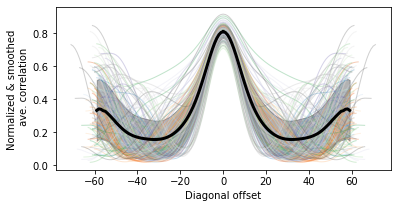

In [7]:
#plot offset and mean_diagonal_sums all together
plt.figure(figsize=(6, 3))
#using cmap to get the color of each line
cmap = plt.get_cmap('tab20c')
#set the color cycle of the plot
plt.gca().set_prop_cycle(color=[cmap(i) for i in np.linspace(0, 1, len(all_offsets.keys()))])
#plot all mean_diagonal_sums


all_half_sum = []
for key in all_offsets.keys():
    Offsets = all_offsets[key]
    mean_diagonal_sums = all_mean_diagonal_sums[key]
    #normalize mean_diagonal_sums to 0 to 1
    mean_diagonal_sums = (mean_diagonal_sums - np.min(mean_diagonal_sums))/(np.max(mean_diagonal_sums) - np.min(mean_diagonal_sums))
    
    #Gaussian smooth the mean_diagonal_sums
    mean_diagonal_sums = gaussian_filter1d(mean_diagonal_sums, sigma=5)
    plt.plot(Offsets, mean_diagonal_sums, alpha=0.3, linewidth=1)
    
    #keep the right half of the mean_diagonal_sums
    half_sum = mean_diagonal_sums[int(len(mean_diagonal_sums)/2):]
    all_half_sum.append(half_sum)
    
#make each elemnt in all_half_sum have the same length, pad np.nan  to the end of the shorter element 
all_half_sum = np.array(all_half_sum)
#max_len = np.max([len(x) for x in all_half_sum])
max_len = 60

all_half_sum = np.array([np.pad(x, (0, max_len-len(x)), 'constant', constant_values=np.nan) if len(x)<max_len else x[:max_len] for x in all_half_sum])
#take nanmean of all_half_sum along the first axis
mean_half_sum = np.nanmean(all_half_sum, axis=0)
#plot mean_half_sum
plt.plot(np.arange(0, len(mean_half_sum)), mean_half_sum, label='mean', linewidth=3, color='k')
#add shaded area of std to the plot
plt.fill_between(np.arange(0, len(mean_half_sum)), mean_half_sum+np.nanstd(all_half_sum, axis=0), mean_half_sum-np.nanstd(all_half_sum, axis=0), alpha=0.3, color='k')
#plot by flipping mean_half_sum to the left side
plt.plot(-np.arange(0, len(mean_half_sum)), mean_half_sum, label='mean', linewidth=3, color='k')
#add shaded area of std to the plot
plt.fill_between(-np.arange(0, len(mean_half_sum)), mean_half_sum+np.nanstd(all_half_sum, axis=0), mean_half_sum-np.nanstd(all_half_sum, axis=0), alpha=0.3, color='k')
plt.xlabel('Diagonal offset')
plt.ylabel('Normalized & smoothed \n ave. correlation')


In [132]:
mean_half_sum

array([1.        , 0.99761864, 0.99013949, 0.97924038, 0.96634508,
       0.95278899, 0.93953759, 0.92714996, 0.9159141 , 0.90595729,
       0.89728749, 0.88982066, 0.88342364, 0.87794993, 0.87326187,
       0.86924437, 0.86579925, 0.862832  , 0.86014465, 0.85754804,
       0.85493564, 0.85233072, 0.84983703, 0.84762049, 0.84540152,
       0.84356965, 0.84179039, 0.84034252, 0.83902345, 0.83794027,
       0.8370309 , 0.83634422, 0.83595862, 0.83571171, 0.83553224,
       0.83544814, 0.83534372, 0.83508326, 0.83470574, 0.83440003,
       0.83400174, 0.83374725, 0.83379174, 0.83421048, 0.83459545,
       0.83588229, 0.83758059, 0.83970056, 0.84228924, 0.84541787,
       0.84908914, 0.85221705, 0.85667531, 0.86045985, 0.86424395,
       0.86659893, 0.86610971, 0.86756409, 0.87086009, 0.87502333,
       0.87508998, 0.86966008, 0.85326012, 0.81854028, 0.8390809 ,
       0.7938554 , 0.7497697 , 0.83790684, 0.80165262, 0.89751921,
       0.97001487, 0.96794469])

In [130]:
all_half_sum.shape

(140, 72)

In [ ]:
#get the average sweep length and replay exponent for each epoch
animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']

all_sweep_len_peranimal = {}; all_sweep_len_perday = {}
all_exponent_peranimal = {}; all_exponent_perday = {}
all_intercept_peranimal = {}; all_intercept_perday = {}
all_ave_speed_peranimal = {}; all_ave_speed_perday = {}
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs = (is_w_track &
                    (epoch_info.n_neurons > MIN_N_NEURONS) &
                    is_animal
                    )


    sweep_len = []
    exponent = []
    intercept = []
    ave_speed = []
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key  
        
        #print load the model of epoch_key
        print(f"Loading data from {animal}_{day:02d}_{epoch:02d}")
        
        #get the average sweep length and replay exponent       
        mean_immobile_speed, mean_sweep_dist, replay_exponent, replay_intercept = get_sweep_and_awake_replay_results(epoch_key, DATA_DIR, sweep_speed_threshold=4)
        
        #print the average sweep length and replay exponent in one line, keep three decimal places
        print(f'Average sweep length: {mean_sweep_dist:.3f}, Diffusion exponent: {replay_exponent:.3f}')
        
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_sweep_len_perday.setdefault((animal, day), []).append(mean_sweep_dist)
        all_exponent_perday.setdefault((animal, day), []).append(replay_exponent)
        all_intercept_perday.setdefault((animal, day), []).append(replay_intercept)
        all_ave_speed_perday.setdefault((animal, day), []).append(mean_immobile_speed)
        
        ave_speed.append(mean_immobile_speed)
        sweep_len.append(mean_sweep_dist)
        exponent.append(replay_exponent)
        intercept.append(replay_intercept)
        
    all_ave_speed_peranimal[name] = ave_speed   
    all_sweep_len_peranimal[name] = sweep_len
    all_exponent_peranimal[name] = exponent
    all_intercept_peranimal[name] = intercept
       

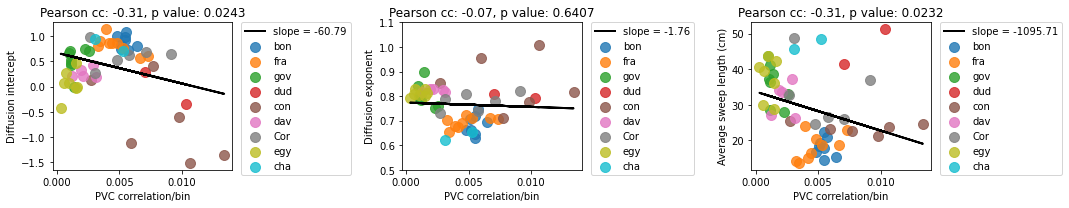

In [116]:
#plot width against replay_exponent for each animal, each with different color in subplot 1
#using all_width_perday, all_sweep_len_perday, all_exponent_perday here

#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_peranimal = {}

#first avearge all the values under each key in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday
all_ave_speed_perday_ave = {}
all_sweep_len_perday_ave = {}
all_exponent_perday_ave = {}
all_intercept_perday_ave = {}
all_corrbin_perday_ave = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_ave[key] = np.mean(all_ave_speed_perday[key])
    all_sweep_len_perday_ave[key] = np.mean(all_sweep_len_perday[key])
    all_exponent_perday_ave[key] = np.mean(all_exponent_perday[key])
    all_intercept_perday_ave[key] = np.mean(all_intercept_perday[key])
    all_corrbin_perday_ave[key] = np.mean(all_corrbin_perday[key])
    
#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_perday_concat = {}
all_sweep_len_perday_concat = {}
all_exponent_perday_concat = {}
all_intercept_perday_concat = {}
all_corrbin_perday_concat = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_concat.setdefault(key[0], []).append(all_ave_speed_perday_ave[key])
    all_sweep_len_perday_concat.setdefault(key[0], []).append(all_sweep_len_perday_ave[key])
    all_exponent_perday_concat.setdefault(key[0], []).append(all_exponent_perday_ave[key])
    all_intercept_perday_concat.setdefault(key[0], []).append(all_intercept_perday_ave[key])
    all_corrbin_perday_concat.setdefault(key[0], []).append(all_corrbin_perday_ave[key])
   
#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(15,3))

plt.subplot(1,3,1)
#plot all_exponent_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_corrbin_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, intercept_np, 1)
plt.plot(corrbin_np, corrbin_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(corrbin_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('PVC correlation/bin')
plt.ylabel('Diffusion intercept')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#intercept
plt.subplot(1,3,2)

#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_corrbin_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
exponent_np = np.concatenate(list(all_exponent_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, exponent_np, 1)
plt.plot(corrbin_np, corrbin_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(corrbin_np, exponent_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('PVC correlation/bin')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

plt.subplot(1,3,3)
#plot all_intercept_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_corrbin_perday_concat[name]), 
                np.array(all_sweep_len_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, sweep_len_np, 1)
plt.plot(corrbin_np, corrbin_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(corrbin_np, sweep_len_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('PVC correlation/bin')
plt.ylabel('Average sweep length (cm)')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()
